In [16]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
import random
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import os
import time
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from torchmetrics.classification import MulticlassConfusionMatrix

In [7]:
# TODO: check that you actually need these transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # test same as val
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
# os.getcwd() outputs /home/joyvan/transfer-learning
# I replaced all the validation stuff with test data because I don't have a
# validation set (this is bad lol)
# TODO: fix above thing
data_dir = 'transfer_learning_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # stores loss/acc values for plotting later
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            # NOTE: I am ignoring the validation phase here
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # populate arrays used for plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                elif phase == 'val':
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)


            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # data for plotting
        plot_data = {
            "train losses": train_losses,
            "train accs": train_accs,
            "val losses": val_losses,
            "val accs": val_accs
        }
            
    return plot_data, model

In [11]:
weights = EfficientNet_V2_L_Weights.DEFAULT
model = efficientnet_v2_l(weights=weights)

# transfer learning (chainging the outputs to be 6 classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

plot_data, model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs = 15)

Epoch 0/14
----------


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 1.2125 Acc: 0.5269
val Loss: 0.8347 Acc: 0.7011

Epoch 1/14
----------
train Loss: 1.0008 Acc: 0.6106
val Loss: 0.7517 Acc: 0.7022

Epoch 2/14
----------
train Loss: 0.9406 Acc: 0.6323
val Loss: 0.7517 Acc: 0.7089

Epoch 3/14
----------
train Loss: 0.8977 Acc: 0.6590
val Loss: 0.6885 Acc: 0.7222

Epoch 4/14
----------
train Loss: 0.8624 Acc: 0.6652
val Loss: 0.7197 Acc: 0.7389

Epoch 5/14
----------
train Loss: 0.8184 Acc: 0.6828
val Loss: 0.6717 Acc: 0.7222

Epoch 6/14
----------
train Loss: 0.7925 Acc: 0.6938
val Loss: 0.6469 Acc: 0.7400

Epoch 7/14
----------
train Loss: 0.7260 Acc: 0.7181
val Loss: 0.6256 Acc: 0.7533

Epoch 8/14
----------
train Loss: 0.7074 Acc: 0.7316
val Loss: 0.6096 Acc: 0.7511

Epoch 9/14
----------
train Loss: 0.7158 Acc: 0.7269
val Loss: 0.6160 Acc: 0.7489

Epoch 10/14
----------
train Loss: 0.6894 Acc: 0.7383
val Loss: 0.6215 Acc: 0.7456

Epoch 11/14
----------
train Loss: 0.6813 Acc: 0.7378
val Loss: 0.6122 Acc: 0.7656

Epoch 12/14
----------
t

Text(0.5, 0, 'Epochs')

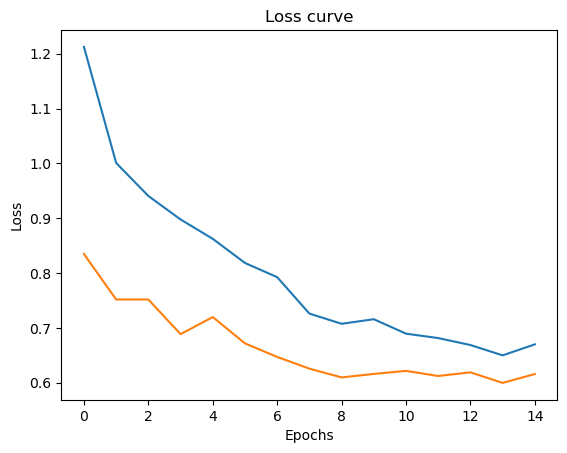

In [12]:
# plot the loss graph
plt.plot(range(15), np.array(torch.tensor(plot_data["train losses"]).cpu().numpy()), label="Train loss")
plt.plot(range(15), plot_data["val losses"], label="Validation loss")
plt.title("Loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

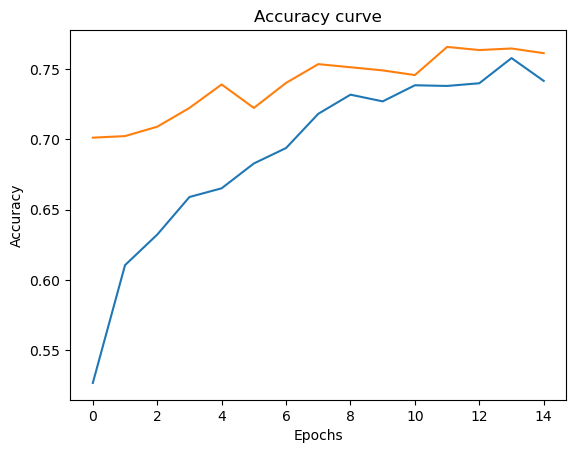

In [15]:
# plot the accuracy graph
plt.plot(range(15), np.array(torch.tensor(plot_data["train accs"]).cpu().numpy()), label="Train accuracy")
plt.plot(range(15), np.array(torch.tensor(plot_data["val accs"]).cpu().numpy()), label="Validation accuracy")
plt.title("Accuracy curve")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

In [19]:
# prettier confusion matrix attempt
def test_model_2(model,dataloaders,device):
    CM=0
    all_labels = []
    all_preds = []
    model.eval()
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            # class_names
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1,2,3,4,5])

        metric = MulticlassConfusionMatrix(num_classes=6)
        metric.update(torch.stack(all_labels, dim=0), torch.stack(all_preds, dim=0))
        fig, ax = metric.plot()

        acc=np.sum(np.diag(CM)/np.sum(CM))
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))


Testset Accuracy(mean): 74.888889 %


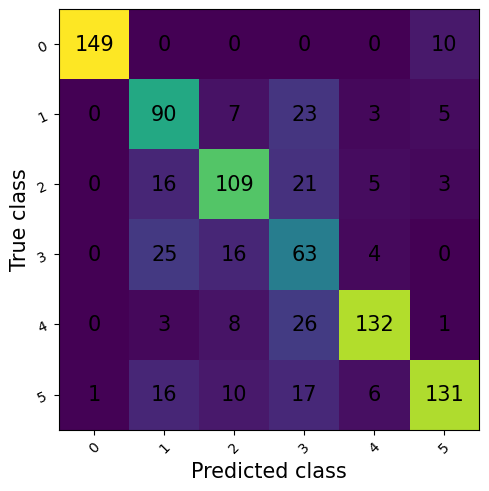

In [20]:
test_model_2(model, dataloaders, device)

In [21]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

true class: Grade4CG


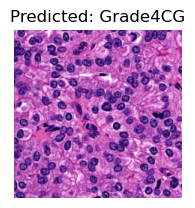

In [49]:
# playing around (do not use this formally)

# get a random image
# data_path
data_path = Path("transfer_learning_dataset/test")

# 1. Get all image paths
image_path_list = list(data_path.glob("*/*.tiff"))

# 2. Pick a random image path and get image
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

print("true class:", image_class)
visualize_model_predictions(
    model,
    img_path=random_image_path
)

plt.ioff()
plt.show()